# Autobatching log-densities example

This notebook demonstrates a simple Bayesian inference example where autobatching makes user code easier to write, easier to read, and less likely to include bugs.

Inspired by a notebook by @davmre.

In [0]:
import functools
import itertools
import re
import sys
import time

from matplotlib.pyplot import *

import jax

from jax import lax
from jax import numpy as np
from jax import scipy
from jax import random

import numpy as onp
import scipy as oscipy

## Generate a fake binary classification dataset

In [0]:
onp.random.seed(10009)

num_features = 10
num_points = 100

true_beta = onp.random.randn(num_features).astype(np.float32)
all_x = onp.random.randn(num_points, num_features).astype(np.float32)
y = (onp.random.rand(num_points) < oscipy.special.expit(all_x.dot(true_beta))).astype(np.int32)

In [3]:
y

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

## Write the log-joint function for the model

We'll write a non-batched version, a manually batched version, and an autobatched version.

### Non-batched

In [0]:
def log_joint(beta):
    result = 0.
    # Note that no `axis` parameter is provided to `np.sum`.
    result = result + np.sum(scipy.stats.norm.logpdf(beta, loc=0., scale=1.))
    result = result + np.sum(-np.log(1 + np.exp(-(2*y-1) * np.dot(all_x, beta))))
    return result

In [5]:
log_joint(onp.random.randn(num_features))

DeviceArray(-213.2356, dtype=float32)

In [6]:
# This doesn't work, because we didn't write `log_prob()` to handle batching.
try:
  batch_size = 10
  batched_test_beta = onp.random.randn(batch_size, num_features)

  log_joint(onp.random.randn(batch_size, num_features))
except ValueError as e:
  print("Caught expected exception " + str(e))

Caught expected exception Incompatible shapes for broadcasting: ((100, 10), (1, 100))


### Manually batched

In [0]:
def batched_log_joint(beta):
    result = 0.
    # Here (and below) `sum` needs an `axis` parameter. At best, forgetting to set axis
    # or setting it incorrectly yields an error; at worst, it silently changes the
    # semantics of the model.
    result = result + np.sum(scipy.stats.norm.logpdf(beta, loc=0., scale=1.),
                           axis=-1)
    # Note the multiple transposes. Getting this right is not rocket science,
    # but it's also not totally mindless. (I didn't get it right on the first
    # try.)
    result = result + np.sum(-np.log(1 + np.exp(-(2*y-1) * np.dot(all_x, beta.T).T)),
                           axis=-1)
    return result

In [8]:
batch_size = 10
batched_test_beta = onp.random.randn(batch_size, num_features)

batched_log_joint(batched_test_beta)

DeviceArray([-147.84033, -207.02205, -109.26076, -243.80832, -163.0291 ,
             -143.8485 , -160.28772, -113.7717 , -126.60544, -190.81992],            dtype=float32)

### Autobatched with vmap

It just works.

In [9]:
vmap_batched_log_joint = jax.vmap(log_joint)
vmap_batched_log_joint(batched_test_beta)

DeviceArray([-147.84033, -207.02205, -109.26076, -243.80832, -163.0291 ,
             -143.8485 , -160.28772, -113.7717 , -126.60544, -190.81992],            dtype=float32)

## Self-contained variational inference example

A little code is copied from above.

### Set up the (batched) log-joint function

In [0]:
@jax.jit
def log_joint(beta):
    result = 0.
    # Note that no `axis` parameter is provided to `np.sum`.
    result = result + np.sum(scipy.stats.norm.logpdf(beta, loc=0., scale=10.))
    result = result + np.sum(-np.log(1 + np.exp(-(2*y-1) * np.dot(all_x, beta))))
    return result

batched_log_joint = jax.jit(jax.vmap(log_joint))

### Define the ELBO and its gradient

In [0]:
def elbo(beta_loc, beta_log_scale, epsilon):
    beta_sample = beta_loc + np.exp(beta_log_scale) * epsilon
    return np.mean(batched_log_joint(beta_sample), 0) + np.sum(beta_log_scale - 0.5 * onp.log(2*onp.pi))
 
elbo = jax.jit(elbo, static_argnums=(1, 2))
elbo_val_and_grad = jax.jit(jax.value_and_grad(elbo, argnums=(0, 1)))

### Optimize the ELBO using SGD

In [12]:
def normal_sample(key, shape):
    """Convenience function for quasi-stateful RNG."""
    new_key, sub_key = random.split(key)
    return new_key, random.normal(sub_key, shape)

normal_sample = jax.jit(normal_sample, static_argnums=(1,))

key = random.PRNGKey(10003)

beta_loc = np.zeros(num_features, np.float32)
beta_log_scale = np.zeros(num_features, np.float32)

step_size = 0.01
batch_size = 128
epsilon_shape = (batch_size, num_features)
for i in range(1000):
    key, epsilon = normal_sample(key, epsilon_shape)
    elbo_val, (beta_loc_grad, beta_log_scale_grad) = elbo_val_and_grad(
        beta_loc, beta_log_scale, epsilon)
    beta_loc += step_size * beta_loc_grad
    beta_log_scale += step_size * beta_log_scale_grad
    if i % 10 == 0:
        print('{}\t{}'.format(i, elbo_val))

0	-180.8538818359375
10	-113.06045532226562
20	-102.73727416992188
30	-99.787353515625
40	-98.90898132324219
50	-98.2974624633789
60	-98.18632507324219
70	-97.57972717285156
80	-97.28599548339844
90	-97.46996307373047
100	-97.4771728515625
110	-97.5806655883789
120	-97.4943618774414
130	-97.50271606445312
140	-96.86396026611328
150	-97.44197845458984
160	-97.06941223144531
170	-96.84027862548828
180	-97.21337127685547
190	-97.56501770019531
200	-97.26397705078125
210	-97.11978912353516
220	-97.39594268798828
230	-97.16831970214844
240	-97.118408203125
250	-97.24346160888672
260	-97.29788970947266
270	-96.69286346435547
280	-96.96438598632812
290	-97.30055236816406
300	-96.63591766357422
310	-97.03518676757812
320	-97.52908325195312
330	-97.28811645507812
340	-97.0732192993164
350	-97.15618896484375
360	-97.25881958007812
370	-97.19514465332031
380	-97.13092041015625
390	-97.11727905273438
400	-96.938720703125
410	-97.26676940917969
420	-97.35322570800781
430	-97.21007537841797
440	-97.

### Display the results

Coverage isn't quite as good as we might like, but it's not bad, and nobody said variational inference was exact.

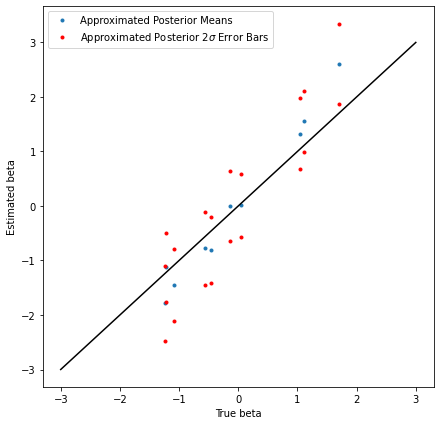

In [13]:
figure(figsize=(7, 7))
plot(true_beta, beta_loc, '.', label='Approximated Posterior Means')
plot(true_beta, beta_loc + 2*np.exp(beta_log_scale), 'r.', label='Approximated Posterior $2\sigma$ Error Bars')
plot(true_beta, beta_loc - 2*np.exp(beta_log_scale), 'r.')
plot_scale = 3
plot([-plot_scale, plot_scale], [-plot_scale, plot_scale], 'k')
xlabel('True beta')
ylabel('Estimated beta')
legend(loc='best')